In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Exploration and Cleaning 

In [3]:
df = pd.read_csv("drive/MyDrive/ML/CHF=X.csv")

#data cleaning & processing 
df.Date = pd.to_datetime(df.Date)
df = df.fillna(method="pad", limit=1)

NB_TEST = int(0.2*len(df))
for i in df.columns[1:]:
  df[i] = pd.to_numeric(df[i])
print(f'Nb Nan: {df.Close.isnull().sum()}')
print(f'Columns name: {df.columns.values}')


Nb Nan: 0
Columns name: ['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']


In [4]:
df2 = pd.read_csv("drive/MyDrive/ML/futures.csv")

#data cleaning & processing 
df2.date = pd.to_datetime(df2.date)

sf = df2['Swiss Frank']
print(f'Nb Nan: {sf.isnull().sum()}')
print(f'Columns name: {df2.columns.values}')


Nb Nan: 0
Columns name: ['date' 'Swiss Frank']


In [5]:
date_lost = set(df.Date) - set(df2.date)
for i in date_lost:
  df= df.drop(df.loc[df['Date']==i].index)
len(df), len(df2)

(4391, 4391)

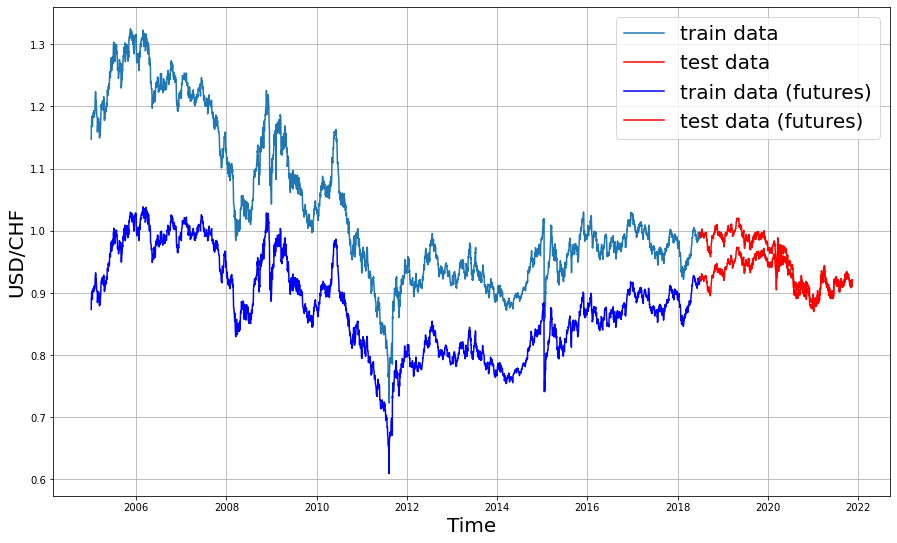

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(df.Date.values[:-NB_TEST],df.Close.values[:-NB_TEST], label="train data")
plt.plot(df.Date.values[-NB_TEST:], df.Close.values[-NB_TEST:], color="r", label="test data")
plt.plot(df.Date.values[:-NB_TEST],1/df2['Swiss Frank'].values[:-NB_TEST], color="b", label="train data (futures)")
plt.plot(df.Date.values[-NB_TEST:], 1/df2['Swiss Frank'].values[-NB_TEST:], color="r", label="test data (futures)")
plt.xlabel("Time", fontsize=20)
plt.ylabel("USD/CHF", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [24]:
df.head(12)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,1.1378,1.1550,1.1374,1.1470,1.1470,0.0
1,2005-01-04,1.1471,1.1706,1.1443,1.1676,1.1676,0.0
2,2005-01-05,1.1676,1.1754,1.1655,1.1669,1.1669,0.0
3,2005-01-06,1.1672,1.1773,1.1667,1.1740,1.1740,0.0
4,2005-01-07,1.1740,1.1885,1.1676,1.1841,1.1841,0.0
5,2005-01-10,1.1837,1.1848,1.1785,1.1794,1.1794,0.0
6,2005-01-11,1.1792,1.1837,1.1733,1.1824,1.1824,0.0
7,2005-01-12,1.1825,1.1840,1.1629,1.1676,1.1676,0.0
8,2005-01-13,1.1676,1.1739,1.1665,1.1721,1.1721,0.0
9,2005-01-14,1.1720,1.1865,1.1720,1.1791,1.1791,0.0


#Dataset 

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

LOOKBACK = 10
NORM = False


train_x = []
train_y = []
test_x = []
test_y = []

inputs = np.zeros((len(df)-LOOKBACK, LOOKBACK))
inputs2 = np.zeros((len(df)-LOOKBACK, LOOKBACK))
labels = np.zeros((len(df)-LOOKBACK, 1))
for i in range(LOOKBACK, len(df)):
    inputs[i-LOOKBACK] = df.Close.iloc[i-LOOKBACK:i].values
    labels[i-LOOKBACK] = df.Close.iloc[i]

# Split data into train and test
train_x = inputs[:-NB_TEST]
train_y = labels[:-NB_TEST]
test_x = inputs[-NB_TEST:]
test_y = labels[-NB_TEST:]

MM = MinMaxScaler()
SS = StandardScaler()

if NORM:
  train_x = MM.fit_transform(train_x)
  train_y = SS.fit_transform(train_y)

  test_x = MM.transform(test_x)
  test_y = SS.transform(test_y)

train_x = train_x.reshape(-1,LOOKBACK, 1)
test_x = test_x.reshape(-1,LOOKBACK, 1)

train_x, train_x_val, train_y, train_y_val =  train_test_split(train_x, train_y, test_size=0.2, shuffle=False) #random_state=0

print(f'Shape: X train {train_x.shape} y train {train_y.shape}; X train val {train_x_val.shape} y train {train_y_val.shape} val ;,  X test {test_x.shape}  y test{test_y.shape}')

Shape: X train (2800, 10, 1) y train (2800, 1); X train val (701, 10, 1) y train (701, 1) val ;,  X test (880, 10, 1)  y test(880, 1)


# Model (Tensors Flow)

In [8]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, BatchNormalization, Conv1D, Flatten, LSTM, RNN
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
result = pd.DataFrame()
EPOCHS = 800
BATCH_SIZE = 512

## Baseline

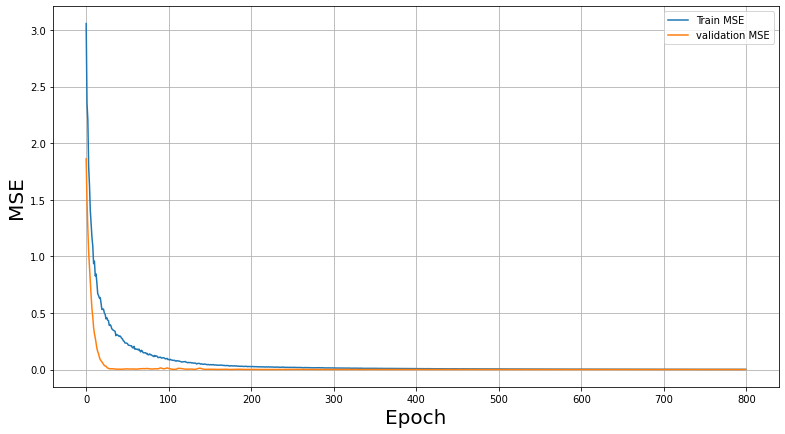

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [10]:
BaselineNet = Sequential()

BaselineNet.add(Dense(32, activation='relu', input_shape=(train_x.shape[1], )))
BaselineNet.add(BatchNormalization())
BaselineNet.add(Dropout(0.2))

BaselineNet.add(Dense(32, activation='relu'))
BaselineNet.add(BatchNormalization())
BaselineNet.add(Dropout(0.2))

BaselineNet.add(Dense(1, activation='linear'))

BaselineNet.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


hist = BaselineNet.fit(train_x, train_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(train_x_val, train_y_val))

result['MSE_train_BaselineNet'] = hist.history['mean_squared_error']
result['MSE_val_BaselineNet'] = hist.history['val_mean_squared_error']

fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_BaselineNet'], label='Train MSE')
plt.plot(result['MSE_val_BaselineNet'] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()

BaselineNet.summary()

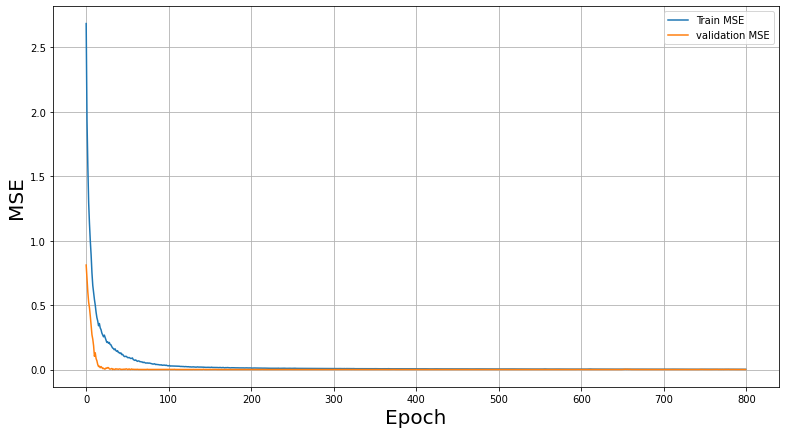

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 batch_normalization_2 (Batc  (None, 8, 16)            64        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 8, 16)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             1568      
                                                                 
 batch_normalization_3 (Batc  (None, 6, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 6, 32)            

In [11]:
ConvNet = Sequential()

ConvNet.add(Conv1D(16, (3,), input_shape=(train_x.shape[1], 1), activation='relu'))
ConvNet.add(BatchNormalization())
ConvNet.add(Dropout(0.2)) 
ConvNet.add(Conv1D(32, (3,), activation='relu'))
ConvNet.add(BatchNormalization())
ConvNet.add(Dropout(0.2)) 
ConvNet.add(Conv1D(64, (3,), activation='relu'))
ConvNet.add(BatchNormalization())
ConvNet.add(Dropout(0.2)) 
ConvNet.add(Conv1D(128, (3,), activation='relu'))
ConvNet.add(BatchNormalization())
ConvNet.add(Dropout(0.2)) 

ConvNet.add(Flatten())

ConvNet.add(Dense(1, activation='linear'))

ConvNet.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

hist = ConvNet.fit(train_x, train_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(train_x_val, train_y_val))

result['MSE_train_ConvNet'] = hist.history['mean_squared_error']
result['MSE_val_ConvNet'] = hist.history['val_mean_squared_error']

fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_ConvNet'], label='Train MSE')
plt.plot(result['MSE_val_ConvNet'] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()


ConvNet.summary()

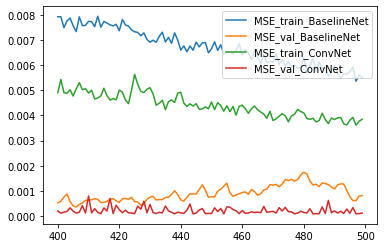

In [14]:
result.iloc[-100:].plot()

## LSTM 

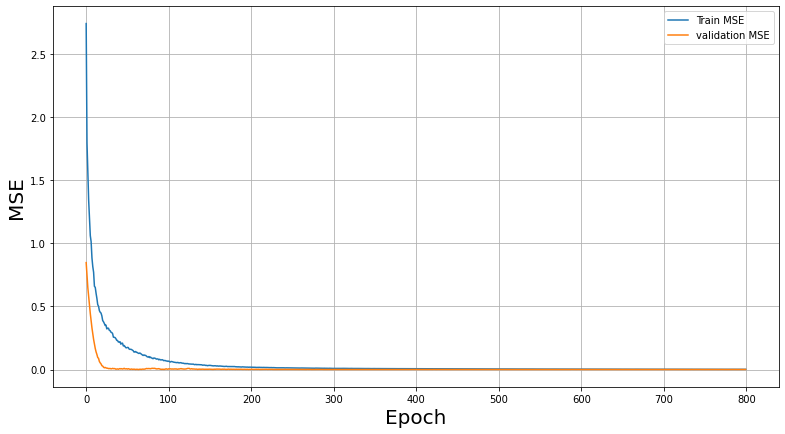

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            16896     
                                                                 
 batch_normalization_6 (Batc  (None, 10, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 batch_normalization_7 (Batc  (None, 10, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 10, 64)           

In [12]:
LSTM_Net = Sequential()

LSTM_Net.add(LSTM(units=64, return_sequences=True, input_shape=(train_x.shape[1], 1)))
LSTM_Net.add(BatchNormalization())
LSTM_Net.add(Dropout(0.2)) 

LSTM_Net.add(LSTM(units=64, return_sequences=True))
LSTM_Net.add(BatchNormalization())
LSTM_Net.add(Dropout(0.2))

LSTM_Net.add(LSTM(units=64, return_sequences=True))
LSTM_Net.add(BatchNormalization())
LSTM_Net.add(Dropout(0.2))

LSTM_Net.add(LSTM(units=64))
LSTM_Net.add(BatchNormalization())
LSTM_Net.add(Dropout(0.2))

LSTM_Net.add(Dense(1, activation='linear'))

LSTM_Net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

hist = LSTM_Net.fit(train_x, train_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(train_x_val, train_y_val))

result['MSE_train_LSTM_Net'] = hist.history['mean_squared_error']
result['MSE_val_LSTM_Net'] = hist.history['val_mean_squared_error']

fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_LSTM_Net'], label='Train MSE')
plt.plot(result['MSE_val_LSTM_Net'] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()


LSTM_Net.summary()

## GRU

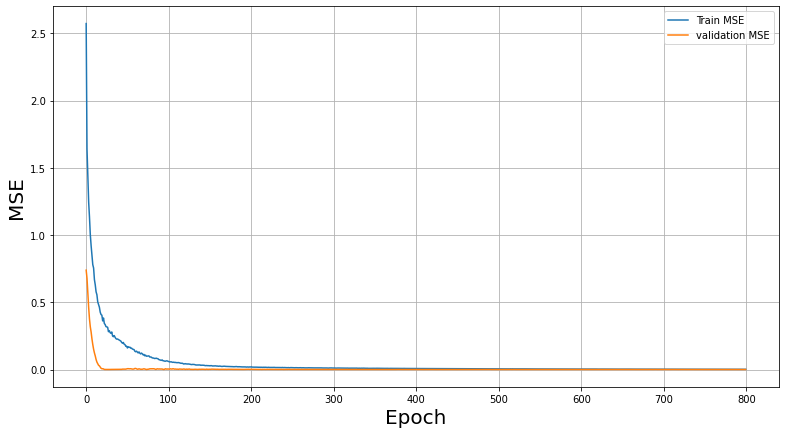

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            12864     
                                                                 
 batch_normalization_10 (Bat  (None, 10, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 10, 64)            24960     
                                                                 
 batch_normalization_11 (Bat  (None, 10, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 10, 64)           

In [13]:
GRU_Net = Sequential()

GRU_Net.add(GRU(units=64, return_sequences=True, input_shape=(train_x.shape[1],1)))
GRU_Net.add(BatchNormalization())
GRU_Net.add(Dropout(0.2)) 

GRU_Net.add(GRU(units=64, return_sequences=True))
GRU_Net.add(BatchNormalization())
GRU_Net.add(Dropout(0.2))


GRU_Net.add(GRU(units=64, return_sequences=True))
GRU_Net.add(BatchNormalization())
GRU_Net.add(Dropout(0.2))


GRU_Net.add(GRU(units=64))
GRU_Net.add(BatchNormalization())
GRU_Net.add(Dropout(0.2))

GRU_Net.add(Dense(1, activation='linear'))

GRU_Net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

hist = GRU_Net.fit(train_x, train_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(train_x_val, train_y_val))

result['MSE_train_GRU_Net'] = hist.history['mean_squared_error']
result['MSE_val_GRU_Net'] = hist.history['val_mean_squared_error']

fig = plt.figure(figsize=(13, 7))
plt.plot(result['MSE_train_GRU_Net'], label='Train MSE')
plt.plot(result['MSE_val_GRU_Net'] , label ='validation MSE')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend()
plt.grid()
plt.show()


GRU_Net.summary()

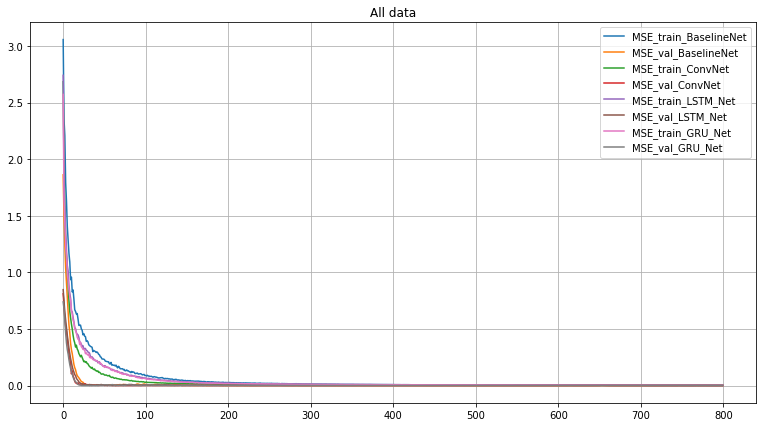

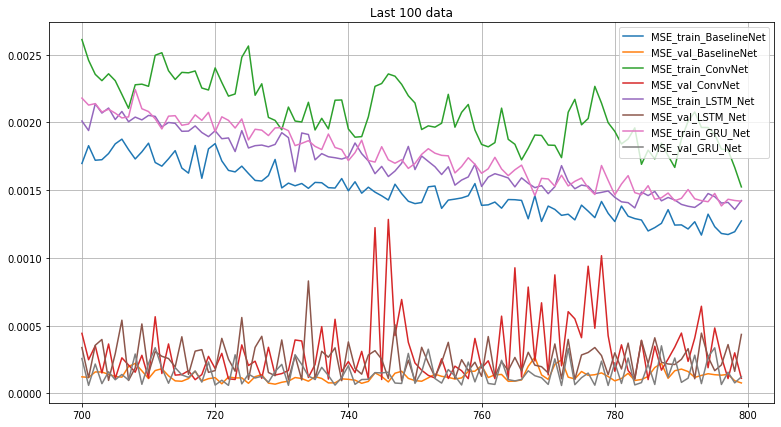

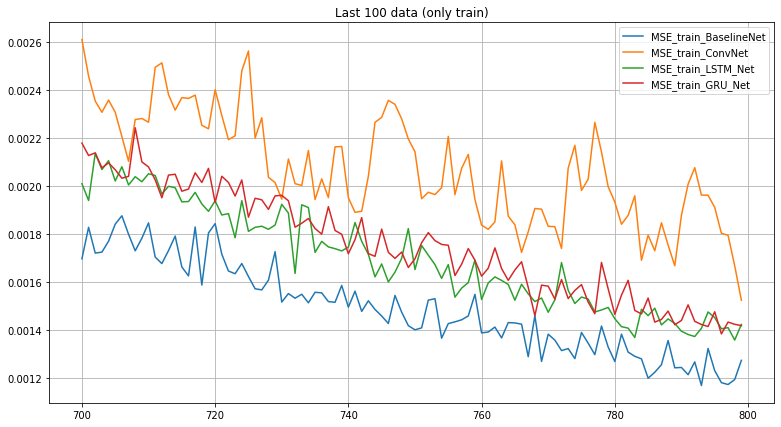

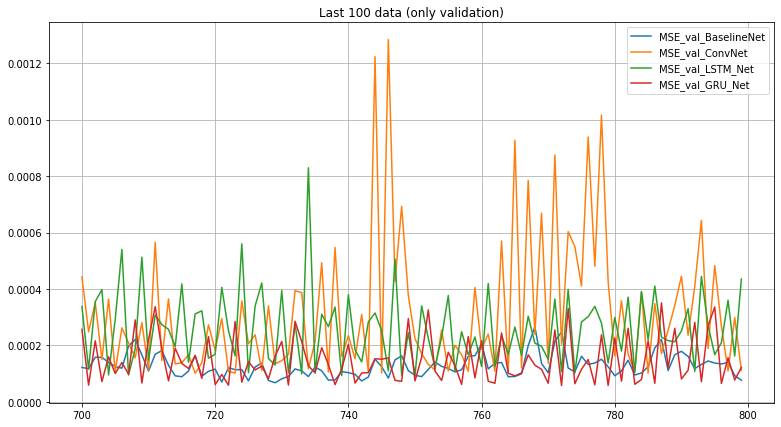

In [16]:

result.plot(figsize=(13, 7))
plt.title("All data")
plt.grid()
plt.show()
nb_data = 100
result.iloc[-nb_data:].plot(figsize=(13, 7))
plt.title("Last "+ str(nb_data)+" data")
plt.grid()
plt.show()
result.iloc[-nb_data:].plot(y=['MSE_train_BaselineNet', 'MSE_train_ConvNet', 'MSE_train_LSTM_Net', 'MSE_train_GRU_Net'], figsize=(13, 7))
plt.title("Last "+ str(nb_data)+" data (only train)")
plt.grid()
plt.show()
result.iloc[-nb_data:].plot(y=['MSE_val_BaselineNet', 'MSE_val_ConvNet', 'MSE_val_LSTM_Net', 'MSE_val_GRU_Net'], figsize=(13, 7))
plt.title("Last "+ str(nb_data)+" data (only validation)")
plt.grid()
plt.show()

# Explore model

88/88 [==============================] - 0s 4ms/step


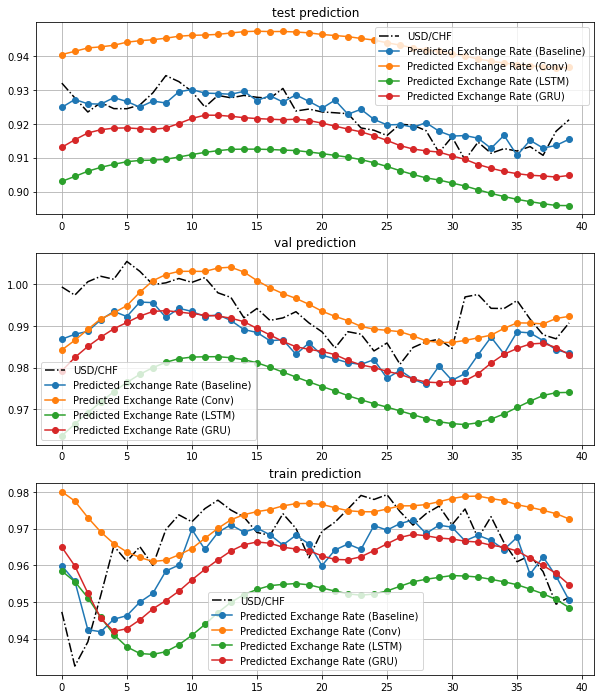

In [20]:
price_test =test_y #SS.inverse_transform(test_y)
price_val = train_y_val#SS.inverse_transform(train_y_val)
price_train = train_y#SS.inverse_transform(train_y)

model = [BaselineNet, ConvNet, LSTM_Net, GRU_Net]
name = ["Baseline", "Conv", "LSTM", "GRU"]
pred_test= []
pred_val= []
pred_train= []
for m in model: 
  pred_test.append(m.predict(test_x))#SS.inverse_transform(m.predict(test_x)))
  pred_val.append(m.predict(train_x_val))#SS.inverse_transform(m.predict(train_x_val)))
  pred_train.append(m.predict(train_x))#SS.inverse_transform(m.predict(train_x)))


nb_data = 40
fig = plt.figure(figsize=(10, 12))

plt.subplot(3,1,1)
plt.title("test prediction")
plt.plot(price_test[-nb_data:], '-.', color = 'black', label = 'USD/CHF')
for i in range(len(model)):
  plt.plot(pred_test[i][-nb_data:], '-o',  label = "Predicted Exchange Rate ("+name[i]+")")
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.title("val prediction")
plt.plot(price_val[-nb_data:], '-.', color = 'black', label = 'USD/CHF')
for i in range(len(model)):
  plt.plot(pred_val[i][-nb_data:], '-o',  label = "Predicted Exchange Rate ("+name[i]+")")
plt.legend()
plt.grid()


plt.subplot(3,1,3)
plt.title("train prediction")
plt.plot(price_train[-nb_data:], '-.', color = 'black', label = 'USD/CHF')
for i in range(len(model)):
  plt.plot(pred_train[i][-nb_data:], '-o',  label = "Predicted Exchange Rate ("+name[i]+")")
plt.legend()
plt.grid()

plt.show()

## OLS metrics 

In [21]:
import statsmodels.api as sm


Y = pred_test[0] #baseline
X = price_test
X = sm.add_constant(X)
model = sm.OLS(Y,X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 5.478e+04
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:20:56   Log-Likelihood:                 3534.5
No. Observations:                 880   AIC:                            -7065.
Df Residuals:                     878   BIC:                            -7055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1121      0.004     31.203      0.0

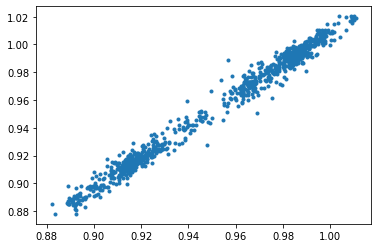

In [22]:
plt.plot(pred_test[0], price_test, '.')